In [1]:
import numpy as np
import pandas as pd

import torch

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
import sys

In [4]:
from copy import deepcopy

In [5]:
sys.path.append('../')
sys.path.append('../../')

In [6]:
from dltranz.util import init_logger, get_conf
from retail_embeddings_projects.embedding_tools.inference_tools import load_model, score_part_of_data

../../retail_embeddings_projects/embedding_tools/inference_tools.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
from sber_finetuning import read_consumer_data

Can not import Transformers


In [8]:
train_target = pd.read_csv('/data/kireev-ia/data_open_ds/age-prediction-nti-sbebank-2019/data/train_target.csv')
train_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


In [9]:
init_logger(__name__)
init_logger('sber_finetuning')
init_logger('dltranz')
init_logger('retail_embeddings_projects.embedding_tools')

In [23]:
args = [
    'data_path=""',
    'model_path.models=["../models/sber_ml_model.p"]',
    'output.path="pca_vectors_embedings"',
    'output.format="pickle"',
    '--conf',
    '../conf/sber_target_dataset.hocon',
    '../conf/sber_ml_params_inference.json',
]
conf = get_conf(args)

2019-12-25 15:27:46,200 INFO    dltranz.util           : args: Namespace(conf=['../conf/sber_target_dataset.hocon', '../conf/sber_ml_params_inference.json']), overrides: ['data_path=""', 'model_path.models=["../models/sber_ml_model.p"]', 'output.path="pca_vectors_embedings"', 'output.format="pickle"']
2019-12-25 15:27:46,207 INFO    dltranz.util           : Load config from "../conf/sber_target_dataset.hocon"
2019-12-25 15:27:46,224 INFO    dltranz.util           : Load config from "../conf/sber_ml_params_inference.json"


In [15]:
model = load_model(conf)

2019-12-25 15:25:47,916 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Models loaded from "['../models/sber_ml_model.p']"


In [12]:
train_data, valid_data = read_consumer_data(conf)

2019-12-25 15:25:35,088 INFO    sber_finetuning        : Data loading...
2019-12-25 15:25:36,915 INFO    sber_finetuning        : Loaded train: 18000, valid: 12000


# Get vectors from model

In [13]:
ix_scores = np.random.choice(np.arange(len(valid_data)), 10000, replace=False)
score_data_orig = [rec for i, rec in enumerate(valid_data) if i in ix_scores]
len(score_data_orig)

10000

In [16]:
model

ModelEnsemble(
  (models): ModuleList(
    (0): Sequential(
      (0): TrxEncoder(
        (embeddings): ModuleDict(
          (trans_date): NoisyEmbedding(
            800, 16, padding_idx=0
            (dropout): Dropout(p=0)
          )
          (small_group): NoisyEmbedding(
            250, 16, padding_idx=0
            (dropout): Dropout(p=0)
          )
        )
      )
      (1): RnnEncoder(
        (rnn): GRU(33, 196, batch_first=True)
      )
      (2): LastStepEncoder()
      (3): L2Normalization()
    )
  )
)

In [20]:
score_model = model.models[0][:-1]
score_model

Sequential(
  (0): TrxEncoder(
    (embeddings): ModuleDict(
      (trans_date): NoisyEmbedding(
        800, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
      (small_group): NoisyEmbedding(
        250, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
    )
  )
  (1): RnnEncoder(
    (rnn): GRU(33, 196, batch_first=True)
  )
  (2): LastStepEncoder()
)

In [21]:
def split_trx(seq):
    def split(rec, pos_s, pos_e):
        rec = deepcopy(rec)
        rec['feature_arrays'] = {k: v[pos_s:pos_e] for k, v in rec['feature_arrays'].items()}
        rec['event_time'] = rec['event_time'][pos_s:pos_e]
        rec['pos_s'] = pos_s
        rec['pos_e'] = pos_e
        return rec        
    
    for rec in seq:
        seq_len = len(rec['event_time'])
        
        for _ in range(10):
            i_len = np.random.randint(0, 1000, 1)[0]
            if i_len > seq_len:
                continue
            pos_s = seq_len - i_len
            if pos_s <= 0:
                pos_s = 0
            else:
                pos_s = np.random.randint(0, seq_len - i_len, 1)[0]
            pos_e = pos_s + i_len
            yield split(rec, pos_s, pos_e)
        
score_data = list(split_trx(score_data_orig))
len(score_data)

86541

In [50]:
score_part_of_data(1, score_data, ['client_id', 'pos_s', 'pos_e'], score_model, conf)
# score_part_of_data(1, score_data, ['client_id', 'pos_s', 'pos_e'], model, conf)

2019-12-25 15:35:23,737 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 1 part of data (86541 records)


2019-12-25 15:35:36,560 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()


2019-12-25 15:35:36,924 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86541, 199):
2019-12-25 15:35:37,055 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86541 records saved to: "pca_vectors_embedings/001.pickle"


In [51]:
df_vectors = pd.read_pickle('pca_vectors_embedings/001.pickle')
df_vectors['seq_len'] = df_vectors['pos_e'] - df_vectors['pos_s']
df_vectors = pd.merge(df_vectors, train_target, on='client_id')

In [52]:
embedding_columns = [col for col in df_vectors.columns if col.startswith('v')]
embedding_columns

['v000',
 'v001',
 'v002',
 'v003',
 'v004',
 'v005',
 'v006',
 'v007',
 'v008',
 'v009',
 'v010',
 'v011',
 'v012',
 'v013',
 'v014',
 'v015',
 'v016',
 'v017',
 'v018',
 'v019',
 'v020',
 'v021',
 'v022',
 'v023',
 'v024',
 'v025',
 'v026',
 'v027',
 'v028',
 'v029',
 'v030',
 'v031',
 'v032',
 'v033',
 'v034',
 'v035',
 'v036',
 'v037',
 'v038',
 'v039',
 'v040',
 'v041',
 'v042',
 'v043',
 'v044',
 'v045',
 'v046',
 'v047',
 'v048',
 'v049',
 'v050',
 'v051',
 'v052',
 'v053',
 'v054',
 'v055',
 'v056',
 'v057',
 'v058',
 'v059',
 'v060',
 'v061',
 'v062',
 'v063',
 'v064',
 'v065',
 'v066',
 'v067',
 'v068',
 'v069',
 'v070',
 'v071',
 'v072',
 'v073',
 'v074',
 'v075',
 'v076',
 'v077',
 'v078',
 'v079',
 'v080',
 'v081',
 'v082',
 'v083',
 'v084',
 'v085',
 'v086',
 'v087',
 'v088',
 'v089',
 'v090',
 'v091',
 'v092',
 'v093',
 'v094',
 'v095',
 'v096',
 'v097',
 'v098',
 'v099',
 'v100',
 'v101',
 'v102',
 'v103',
 'v104',
 'v105',
 'v106',
 'v107',
 'v108',
 'v109',
 'v110',
 

In [53]:
df_vectors.head(20)

,client_id,pos_s,pos_e,v000,v001,v002,v003,v004,v005,v006,...,v188,v189,v190,v191,v192,v193,v194,v195,seq_len,bins
0,11,381,558,-0.410138,-0.971240,-0.612150,0.273910,-0.970198,-0.470088,-0.719568,...,0.179648,-0.246797,-0.010090,0.810188,0.879849,-0.018490,-0.770780,0.321777,177,3
1,11,166,656,-0.406554,-0.985224,-0.735145,0.299888,-0.985964,-0.353295,-0.771842,...,0.216032,-0.253456,-0.038721,0.913550,0.909813,-0.009214,-0.864334,0.179197,490,3
2,11,362,658,-0.396599,-0.978348,-0.690065,0.273501,-0.976443,-0.385704,-0.760025,...,0.169466,-0.262478,-0.012629,0.848655,0.880415,0.001217,-0.812400,0.209996,296,3
3,11,86,443,-0.462803,-0.987567,-0.662787,0.331397,-0.987347,-0.302445,-0.764584,...,0.255833,-0.224148,-0.074482,0.942208,0.898195,-0.091232,-0.900777,0.091228,357,3
4,11,16,782,-0.389713,-0.987929,-0.793931,0.306395,-0.989593,-0.335133,-0.831481,...,0.178121,-0.255383,-0.055976,0.922959,0.927968,-0.022699,-0.850742,0.233945,766,3
5,11,319,604,-0.406991,-0.980897,-0.691280,0.276171,-0.980921,-0.351124,-0.751352,...,0.211778,-0.255808,-0.032034,0.891533,0.898894,0.021151,-0.839758,0.170722,285,3
6,11,10,773,-0.390339,-0.986540,-0.793469,0.307129,-0.989736,-0.334505,-0.832022,...,0.178715,-0.253042,-0.056624,0.923991,0.928061,-0.022877,-0.851253,0.233393,763,3
7,11,287,663,-0.405838,-0.981488,-0.705965,0.281755,-0.981024,-0.362421,-0.749029,...,0.171737,-0.246483,-0.047639,0.886785,0.896644,0.007845,-0.829173,0.175006,376,3
8,11,517,790,-0.348816,-0.958763,-0.629936,0.253469,-0.933949,-0.388496,-0.646743,...,0.109850,-0.264895,-0.021016,0.870161,0.806648,0.042936,-0.813160,0.423392,273,3
9,11,15,775,-0.390623,-0.987876,-0.792822,0.307185,-0.989716,-0.335350,-0.831887,...,0.179398,-0.255710,-0.056658,0.923714,0.927189,-0.024182,-0.850452,0.232784,760,3


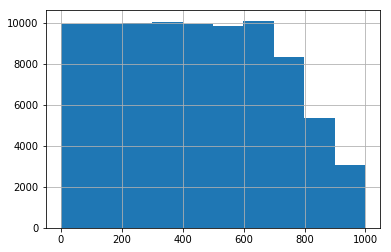

In [54]:
df_vectors['seq_len'].hist()

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [88]:
df_pca = df_vectors.copy()

In [97]:
pca = PCA(n_components=2)
pca.fit(df_pca[embedding_columns].values)
np.sum(pca.explained_variance_ratio_)

0.35239537493595485

In [98]:
pca_results = pca.transform(df_pca[embedding_columns].values)
df_pca['_pca_x'] = pca_results[:, 0]
df_pca['_pca_y'] = pca_results[:, 1]

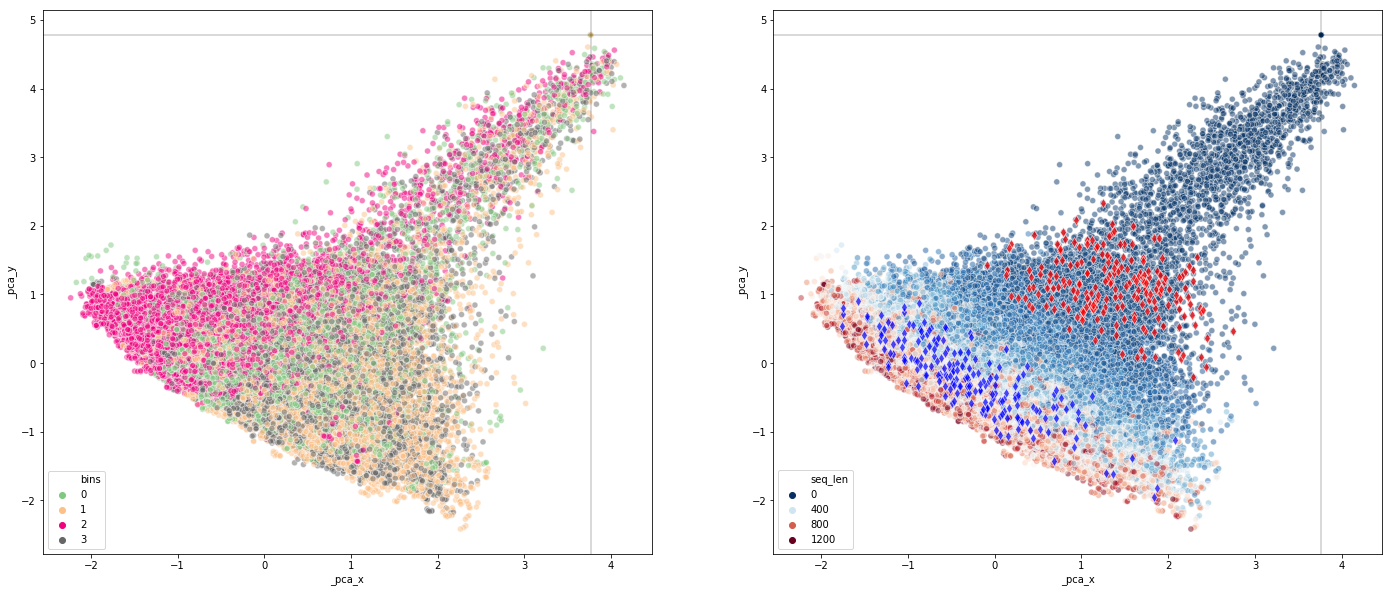

In [99]:
_, axs = plt.subplots(1, 2, figsize=(12 * 2, 10))

cmap = plt.get_cmap('tab10')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='bins',
    data=df_pca,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='seq_len',
    data=df_pca,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')
for i in range(0):
    _t = df_pca[lambda x: x.client_id.eq(np.random.choice(df_pca.client_id.unique(), 1)[0])] \
        .sort_values(['seq_len', 'pos_s', 'pos_e'])
    axs[1].plot(_t['_pca_x'], _t['_pca_y'], color=cmap(i+1), linewidth=3)
    t = axs[1].text(_t.iloc[0]['_pca_x'], _t.iloc[0]['_pca_y'], str(int(_t.iloc[0]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})
    t = axs[1].text(_t.iloc[-1]['_pca_x'], _t.iloc[-1]['_pca_y'], str(int(_t.iloc[-1]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    data=df_pca[lambda x: x['seq_len'].between(23, 26)].sample(n=200),
    color='red', marker='d', s=50,
    alpha=0.7,
    ax=axs[1],
)

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    data=df_pca[lambda x: x['seq_len'].between(580, 620)].sample(n=200),
    color='blue', marker='d', s=50,
    alpha=0.7,
    ax=axs[1],
)

Относительный порядок категорий: 1 - 3 - 0 - 2

In [82]:
df_pca = df_vectors[lambda x: x.seq_len >= 25].copy()

In [83]:
pca = PCA(n_components=2)
pca.fit(df_pca[embedding_columns].values)
np.sum(pca.explained_variance_ratio_)

0.3321521836203781

In [84]:
pca_results = pca.transform(df_pca[embedding_columns].values)
df_pca['_pca_x'] = pca_results[:, 0]
df_pca['_pca_y'] = pca_results[:, 1]

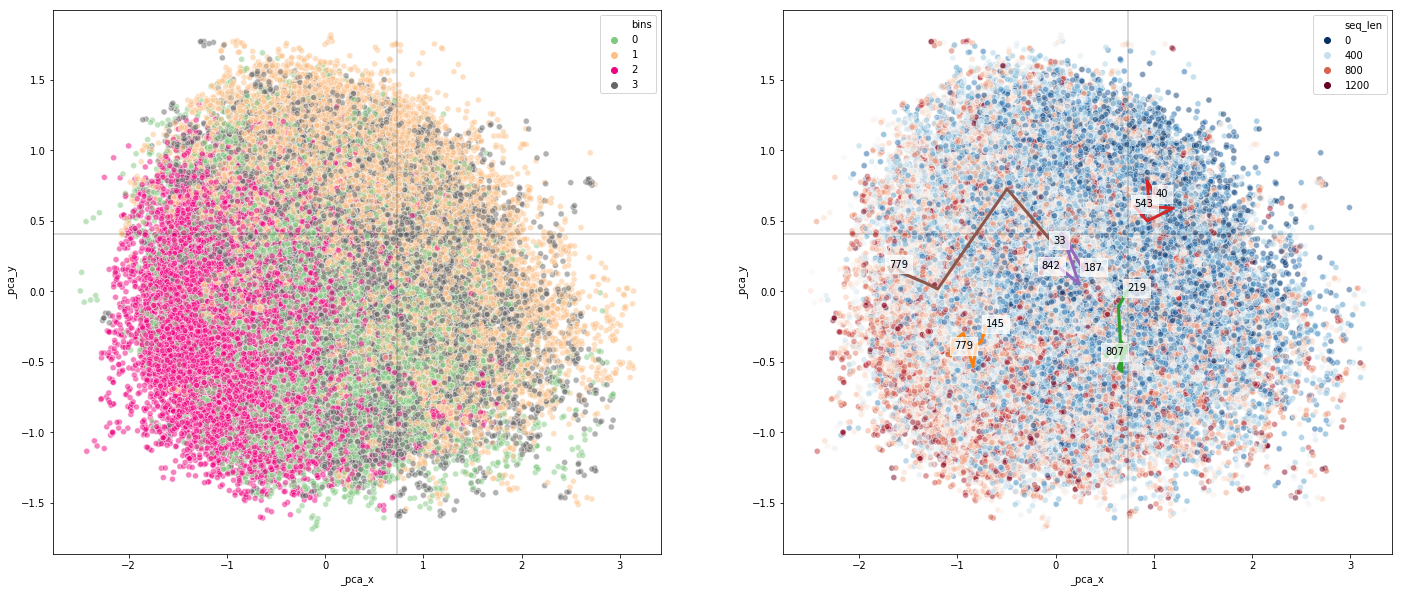

In [87]:
_, axs = plt.subplots(1, 2, figsize=(12 * 2, 10))

cmap = plt.get_cmap('tab10')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='bins',
    data=df_pca,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='seq_len',
    data=df_pca,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')
for i in range(5):
    _t = df_pca[lambda x: x.client_id.eq(np.random.choice(df_pca.client_id.unique(), 1)[0])] \
        .sort_values(['seq_len', 'pos_s', 'pos_e'])
    axs[1].plot(_t['_pca_x'], _t['_pca_y'], color=cmap(i+1), linewidth=3)
    t = axs[1].text(_t.iloc[0]['_pca_x'], _t.iloc[0]['_pca_y'], str(int(_t.iloc[0]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})
    t = axs[1].text(_t.iloc[-1]['_pca_x'], _t.iloc[-1]['_pca_y'], str(int(_t.iloc[-1]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})


,client_id,pos_s,pos_e,v000,v001,v002,v003,v004,v005,v006,...,v190,v191,v192,v193,v194,v195,seq_len,bins,_pca_x,_pca_y
7642,4331,219,244,-0.324080,-0.949235,-0.370147,0.163501,-0.895684,-0.464923,-0.757487,...,-0.029846,0.723122,0.905911,-0.096611,-0.080757,0.391376,25,2,-0.193201,1.424098
62548,36224,250,275,-0.344502,-0.921142,-0.396794,0.179094,-0.855141,-0.460024,-0.842196,...,-0.030699,0.637450,0.864632,-0.107927,-0.113295,0.395557,25,2,0.090243,1.314153
8271,4651,214,239,-0.310976,-0.882599,-0.261282,0.187629,-0.879241,-0.458056,-0.674541,...,-0.002071,0.657687,0.823571,-0.002389,-0.292115,0.284133,25,2,0.115989,1.558573
13429,7329,437,462,-0.350582,-0.903912,-0.400386,0.181594,-0.845045,-0.609200,-0.711722,...,-0.028325,0.663639,0.839179,-0.170041,-0.279456,0.237251,25,1,0.265570,1.052478
59347,34447,226,251,-0.416177,-0.917474,-0.288543,0.235764,-0.830369,-0.461471,-0.500519,...,-0.035521,0.740821,0.699901,-0.082197,-0.683774,0.261179,25,2,0.267744,0.954274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37140,21249,278,303,-0.101987,-0.895130,-0.466184,0.185661,-0.621996,-0.606218,-0.755621,...,-0.283915,0.794213,0.221762,-0.247715,-0.712106,0.172172,25,0,2.286917,-0.200494
82231,47482,666,691,-0.336991,-0.662254,-0.230635,0.211891,-0.482409,-0.597327,-0.178607,...,-0.036190,0.559873,-0.019828,-0.211188,-0.607764,0.347179,25,1,2.375935,0.761948
29279,16244,540,565,-0.351116,-0.617480,-0.192204,0.244536,-0.453450,-0.695290,-0.339998,...,-0.137484,0.501564,0.133065,-0.149701,-0.524109,0.226844,25,1,2.396108,0.770612
53038,30743,10,35,-0.338485,-0.725217,-0.176814,0.206596,-0.617390,-0.543047,-0.458872,...,-0.202954,0.258568,0.024559,-0.188892,-0.703081,0.362646,25,1,2.445097,0.361405


In [60]:
if len(df_pca) > 10000:
    df_tsne = df_pca.sample(n=10000).copy()
else:
    df_tsne = df_pca.copy()

In [61]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(df_tsne[embedding_columns].values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.075s...
[t-SNE] Computed neighbors for 10000 samples in 45.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.499035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.911255
[t-SNE] KL divergence after 300 iterations: 3.585788


In [62]:
df_tsne['_tsne_x'] = tsne_results[:, 0]
df_tsne['_tsne_y'] = tsne_results[:, 1]

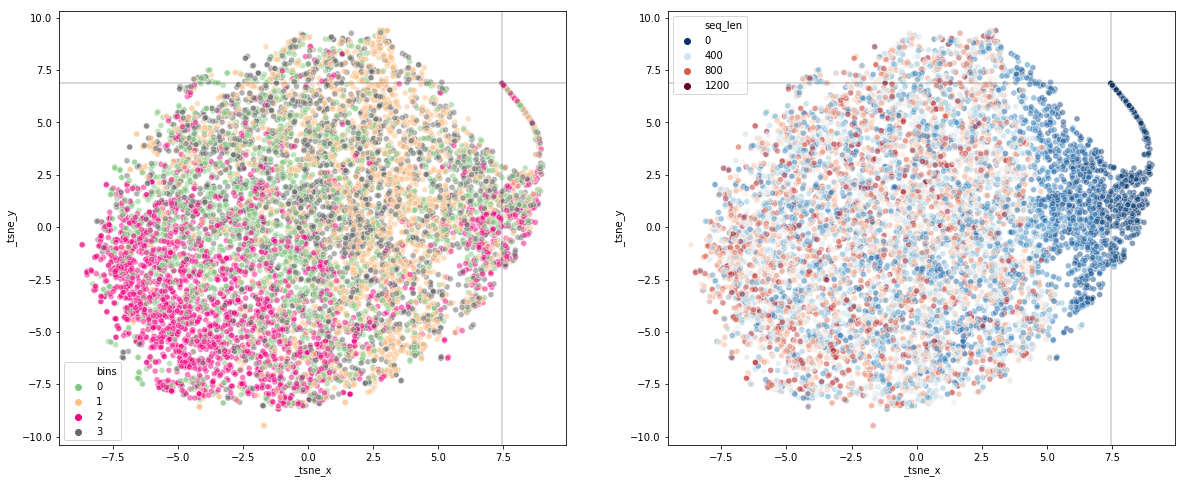

In [63]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='bins',
    data=df_tsne,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='seq_len',
    data=df_tsne,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')